In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import math as ma
import seaborn as sns
import h5py
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from astropy import constants
from scipy import stats
from astropy.io import fits
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve

In [2]:
def df_key(x,y,z):
    return str('o'+str(int(x))+'t'+str(int(y))+'f'+str(int(z)))

def loc_key(x,y):
    return str('ra'+str(x)+'dec'+str(y))

### Read detected outlier data

def load_outliers_from_h5(file_path, polarizations):
    with h5py.File(file_path, "r") as f:
        outliers_mask = f["wins_z_score"][:]
        obs_id = f["obs_id"][:].astype(str)
        time_blocks = f["time_blocks"][:]

    print("Outliers: ", outliers_mask.shape)

    flat_data = outliers_mask.reshape(-1, outliers_mask.shape[-1])
    
    # Create DataFrame
    df_outliers = pd.DataFrame(flat_data, columns=["XX", "XY", "YX", "YY"])

    df_outliers["obs_id"] = np.tile(obs_id, outliers_mask.shape[1]*outliers_mask.shape[2])
    df_outliers["time_index"] = np.repeat(np.arange(outliers_mask.shape[0]), outliers_mask.shape[1] * outliers_mask.shape[2])
    df_outliers["frequency"] = np.tile(np.arange(outliers_mask.shape[2]), outliers_mask.shape[0] * outliers_mask.shape[1])
    df_outliers["antenna"] = np.tile(np.repeat(np.arange(outliers_mask.shape[1]), outliers_mask.shape[2]), outliers_mask.shape[0])
    df_outliers["obs_id"] = df_outliers['time_index'].map(lambda t: int(obs_id[t]))
    df_outliers["timeblock"] = df_outliers['time_index'].map(lambda t: int(time_blocks[t]))

    selected_polarizations = polarizations  

    # Filter rows where any of the selected columns is True
    df_outliers = df_outliers[df_outliers[selected_polarizations].any(axis=1)].reset_index(drop=True)

    return df_outliers

In [3]:
observation_file = "/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/observation_id/observation_id.csv"

df = pd.read_csv(observation_file, header=0, engine='python')
df = df[['obs_id', 'groupid', 'starttime_utc', 'local_sidereal_time_deg', 'duration',
        'int_time', 'freq_res', 'dataqualityname', 'bad_tiles', 'calibration',
        'calibration_delays', 'center_frequency_mhz', 'channel_center_frequencies_mhz_csv',
        'ra', 'ra_pointing', 'ra_phase_center', 'dec', 'dec_pointing', 'dec_phase_center',
        'deleted_flag', 'good_tiles', 'mode', 'sky_temp', 'stoptime_utc', 'total_tiles', 'gridpoint_name', 'gridpoint_number']]
df['date'] = df.starttime_utc.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.000Z").date())
df['partition'] = pd.factorize(df['date'])[0] + 1
df = df[df['partition'] == 1].reset_index(drop=True)

obs_list = df['obs_id'].to_list()
gn = np.unique(df['gridpoint_number'])

In [6]:
outlier_path = "/Volumes/eor_hdd_2/results_model_revision_251128/"
#outlier_path = "/Volumes/eor_hdd_2/results_model_revision_251128_5_5/"
added_rfi_path = "/Users/eormacstudio/Documents/winsorized_statistics/winsorizing_model_visibility/higher_thermal_noise/same_level_noise/"

threshold_type = ['negative', 'positive', 'combine']
polarizations = ["XX"] #, "YY"]
parts = ["real", "imaginary", "amplitude", "phase"]
sn = ['sn1', 'sn5', 'sn3', 'sn4', 'sn2']
integ = ['8s'] #, '2s']

level = ['901.59', '1298.45', '1620.04', '1906.17', '2176.54']
df_rfi_level = pd.DataFrame({'sn' : sn, 'level' : level})

time_convert = np.repeat(np.arange(0,14), 4)
tile_list = np.arange(0, 128, 1)
z_score = np.arange(2, 14, 1)

cal_pol_alias = pd.DataFrame({
    'pol': ['XX', 'XY', 'YX', 'YY']})
cal_pol_alias = cal_pol_alias.reset_index()

vis_pol_alias = pd.DataFrame({
    'pol': ['XX', 'YY', 'XY', 'YX']})
vis_pol_alias = vis_pol_alias.reset_index()

z_alias = pd.DataFrame({
    'z_score': z_score})
z_alias = z_alias.reset_index(drop=True)

In [7]:
df_stats = pd.DataFrame()

for i in range(len(parts)):
    for j in range(2): #len(sn)):
        for k in range(1): #len(polarizations)):
            for l in range(len(integ)):
                print(parts[i], sn[j], polarizations[k], integ[l])

                # Added outliers

                df_rfi = pd.read_csv(added_rfi_path+ "%s/add_rfi_all_obs_location_multiple_rfi_fix_thermal_%s.txt" %(sn[j], sn[j]))
                df_rfi['pol_1'] = df_rfi['pol_1'].apply(lambda x: str(x).replace('[', '').replace(']', ''))
                df_rfi['pol_1'] = df_rfi['pol_1'].astype(int)
                df_rfi['polarization'] = df_rfi.pol_1.map(vis_pol_alias.set_index('index')['pol'])
                df_rfi = df_rfi[df_rfi['polarization'] == polarizations[k]].reset_index(drop=True)

                if integ[l] == '2s':
                    df_rfi['rfi_key'] = df_rfi.apply(lambda x: df_key(x['obs_id'], x['timeblock'], x['channel']),  axis=1)
                    df_rfi = df_rfi.drop_duplicates(subset=['rfi_key'], keep='last').reset_index(drop=True)
                    df_rfi['alias'] = 1
                elif integ[l] == '8s':
                    df_rfi['timeblock_alias'] = df_rfi['timeblock'].apply(lambda x: time_convert[x])
                    df_rfi['rfi_key'] = df_rfi.apply(lambda x: df_key(x['obs_id'], x['timeblock_alias'], x['channel']),  axis=1)
                    df_rfi = df_rfi.drop_duplicates(subset=['rfi_key'], keep='last').reset_index(drop=True)
                    df_rfi['alias'] = 1
                
                #print(df_rfi)

                df_detected_outliers = pd.DataFrame()
                for o in range(len(gn)):
                    print(outlier_path+"%s/%s/%s/win_z_scores_data_day_1_grid_%s_integration_%s_%s_part_1_gp_%s.h5" %(sn[j], integ[l], parts[i], gn[o], integ[l][0], parts[i], gn[o]))
                    
                    aa = load_outliers_from_h5(outlier_path+"%s/%s/%s/win_z_scores_data_day_1_grid_%s_integration_%s_%s_part_1_gp_%s.h5" %(sn[j], integ[l], parts[i], gn[o], integ[l][0], parts[i], gn[o]), polarizations)
                    df_detected_outliers = pd.concat([df_detected_outliers, aa]).reset_index(drop = True)

                for m in range(len(z_score)):
                    print('running for z-score: ', z_score[m])
                    for n in range(len(threshold_type)):
                        print(threshold_type[n])
                        
                        # Reduce df_detected_outliers
                        if threshold_type[n] == 'positive':
                            ss = df_detected_outliers[(df_detected_outliers[polarizations[k]] > z_score[m])].reset_index(drop=True)
                        elif threshold_type[n] == 'negative':
                            ss = df_detected_outliers[(df_detected_outliers[polarizations[k]] < -z_score[m])].reset_index(drop=True)
                        elif threshold_type[n] == 'combine':
                            ss = df_detected_outliers[np.abs(df_detected_outliers[polarizations[k]]) > z_score[m]].reset_index(drop=True)

                        #print('ss: ', ss)
                        if len(ss) != 0:

                            ss['rfi_key'] = ss.apply(lambda x: df_key(x['obs_id'], x['timeblock'], x['frequency']),  axis=1)

                            ss = ss.drop_duplicates(subset=['rfi_key'], keep='last').reset_index(drop=True)
                            ss['alias'] = 1

                            if integ[l] == '2s':
                                # Create default dataframe
                                # Step 1: Create the data

                                data_A = np.arange(0, 56)
                                data_B = np.arange(0, 768)

                                # Step 2: Generate the Cartesian product

                                column_A = np.repeat(obs_list, len(data_A) * len(data_B))
                                column_B = np.tile(np.repeat(data_A, len(data_B)), len(obs_list))
                                column_C = np.tile(data_B, len(obs_list) * len(data_A))

                                # Step 3: Construct the DataFrame

                                df = pd.DataFrame({
                                    'obs_id': column_A,
                                    'timeblocks': column_B,
                                    'freqs': column_C
                                })

                            elif integ[l] == '8s':
                                # Create default dataframe
                                # Step 1: Create the data

                                data_A = np.arange(0, 14)
                                data_B = np.arange(0, 768)

                                # Step 2: Generate the Cartesian product

                                column_A = np.repeat(obs_list, len(data_A) * len(data_B))
                                column_B = np.tile(np.repeat(data_A, len(data_B)), len(obs_list))
                                column_C = np.tile(data_B, len(obs_list) * len(data_A))

                                # Step 3: Construct the DataFrame

                                df = pd.DataFrame({
                                    'obs_id': column_A,
                                    'timeblocks': column_B,
                                    'freqs': column_C
                                })

                            df['rfi_key'] = df.apply(lambda x: df_key(x['obs_id'], x['timeblocks'], x['freqs']),  axis=1)
                            df['added_rfi'] = df.rfi_key.map(df_rfi.set_index('rfi_key')['alias'])
                            df['detected_rfi'] = df.rfi_key.map(ss.set_index('rfi_key')['alias'])
                            df = df.fillna(0)

                            #print(df)

                            # Calculate all metrics
                            cm = confusion_matrix(df['added_rfi'], df['detected_rfi'])

                            accuracy = accuracy_score(df['added_rfi'], df['detected_rfi'])
                            precision = precision_score(df['added_rfi'], df['detected_rfi'])
                            recall = recall_score(df['added_rfi'], df['detected_rfi'])
                            f1 = f1_score(df['added_rfi'], df['detected_rfi'])

                            TN = cm[0,0]
                            FP = cm[0,1]
                            FN = cm[1,0]
                            TP = cm[1,1]

                            fsdata = {'plot_type': [parts[i]],
                                    'sn': [sn[j]],
                                    'polarization': [polarizations[k]],
                                    'total_rfi': [len(df_rfi)],
                                    'integration': [integ[l]],
                                    'z_score': [z_score[m]],
                                    'threshold_type': [threshold_type[n]],
                                    'accuracy': [accuracy],
                                    'precision': [precision],
                                    'recall': [recall],
                                    'f1': [f1],
                                    'tp': [TP],
                                    'fp': [FP],
                                    'tn': [TN],
                                    'fn': [FN]}
                            
                            # Create the DataFrame
                            bb = pd.DataFrame(fsdata)
                            df_stats = pd.concat([df_stats, bb]).reset_index(drop = True)
                            
                        else:
                            continue

df_stats['tp_rate'] = df_stats['tp']/df_stats['total_rfi']
df_stats['fp_rate'] = df_stats['fp']/(df_stats['fp'] + df_stats['tn'])

real sn1 XX 8s
/Volumes/eor_hdd_2/results_model_revision_251128/sn1/8s/real/win_z_scores_data_day_1_grid_0_integration_8_real_part_1_gp_0.h5
Outliers:  (224, 128, 768, 4)
/Volumes/eor_hdd_2/results_model_revision_251128/sn1/8s/real/win_z_scores_data_day_1_grid_1_integration_8_real_part_1_gp_1.h5
Outliers:  (112, 128, 768, 4)
/Volumes/eor_hdd_2/results_model_revision_251128/sn1/8s/real/win_z_scores_data_day_1_grid_2_integration_8_real_part_1_gp_2.h5
Outliers:  (126, 128, 768, 4)
running for z-score:  2
negative
positive
combine
running for z-score:  3
negative
positive
combine
running for z-score:  4
negative
positive
combine
running for z-score:  5
negative
positive
combine
running for z-score:  6
negative
positive
combine
running for z-score:  7
negative
positive
combine
running for z-score:  8
negative
positive
combine
running for z-score:  9
negative
positive
combine
running for z-score:  10
negative
positive
combine
running for z-score:  11
negative
positive
combine
running for z-s

In [ ]:
df_stats[(df_stats['plot_type'] == 'real') & (df_stats['threshold_type'] == 'negative')]

In [ ]:
sel_df = df_stats[(df_stats['integration'] == integ[jj]) & (df_stats['plot_type'] == parts[ii]) & (df_stats['sn'] == sn[ll]) & (df_stats['threshold_type'] == threshold_type[kk])][['z_score', 'tp', 'fp', 'f1']].reset_index(drop=True)

In [ ]:
z_alias['tp'] = z_alias.z_score.map(sel_df.set_index('z_score')['tp'])
z_alias['fp'] = z_alias.z_score.map(sel_df.set_index('z_score')['fp'])
z_alias['f1'] = z_alias.z_score.map(sel_df.set_index('z_score')['f1'])

In [ ]:
z_alias

/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eormacstudio/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


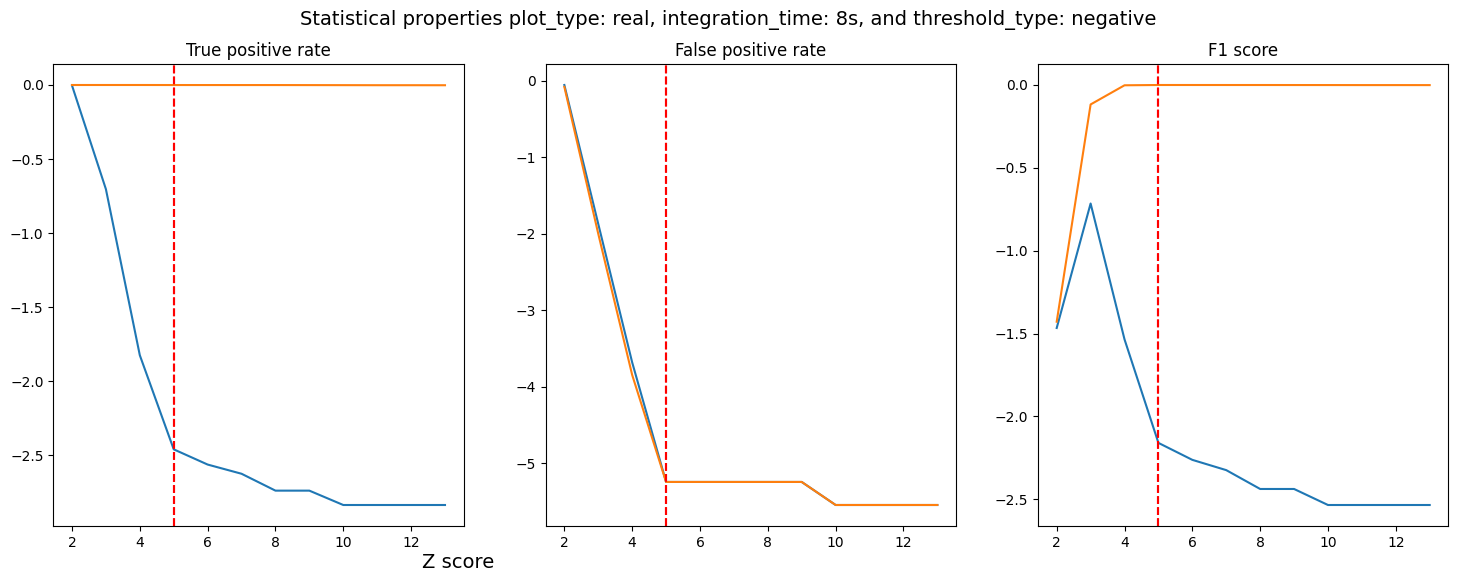

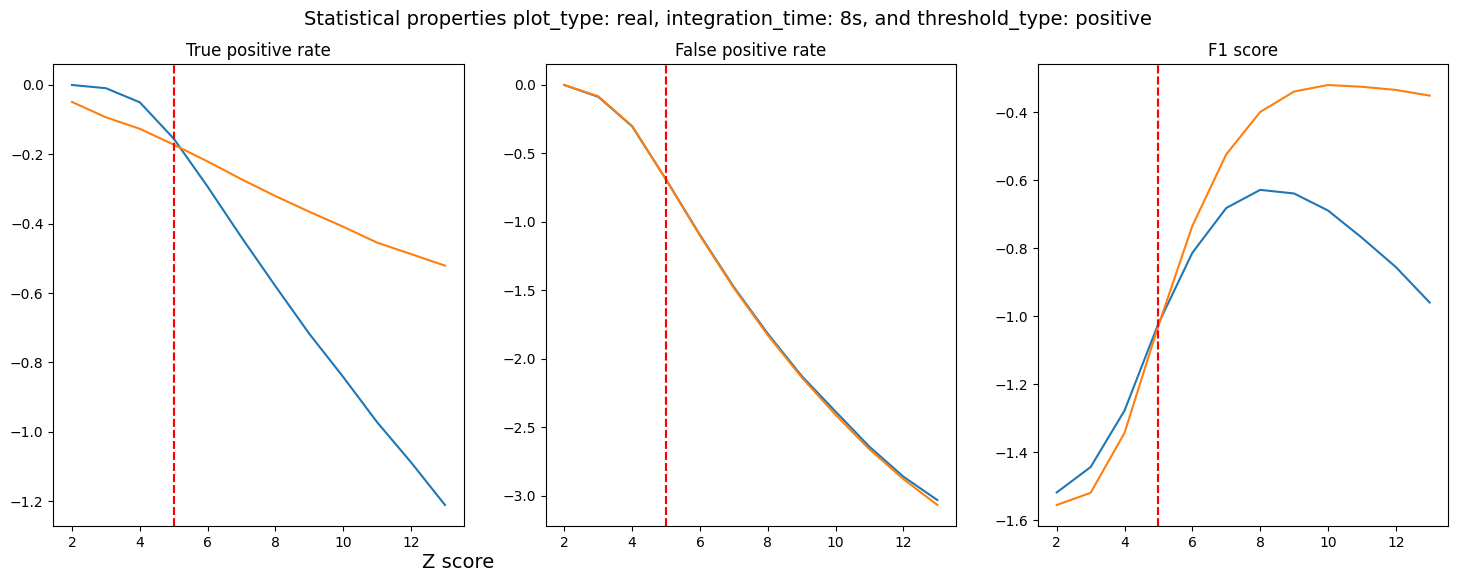

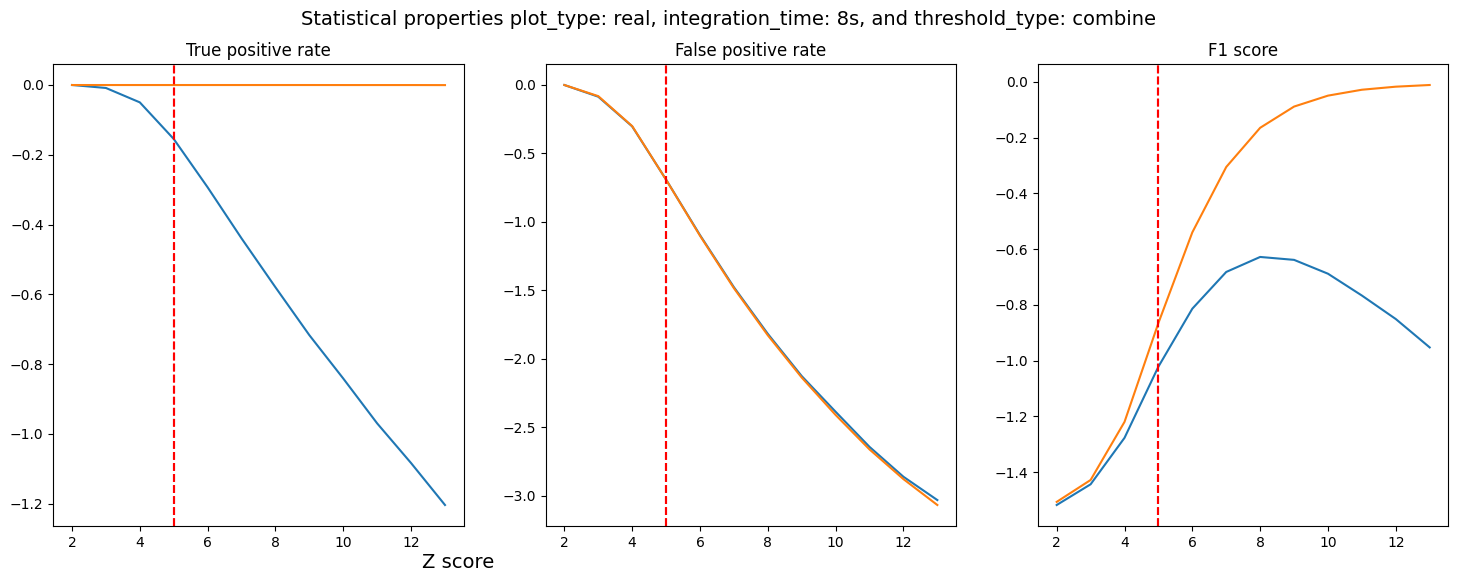

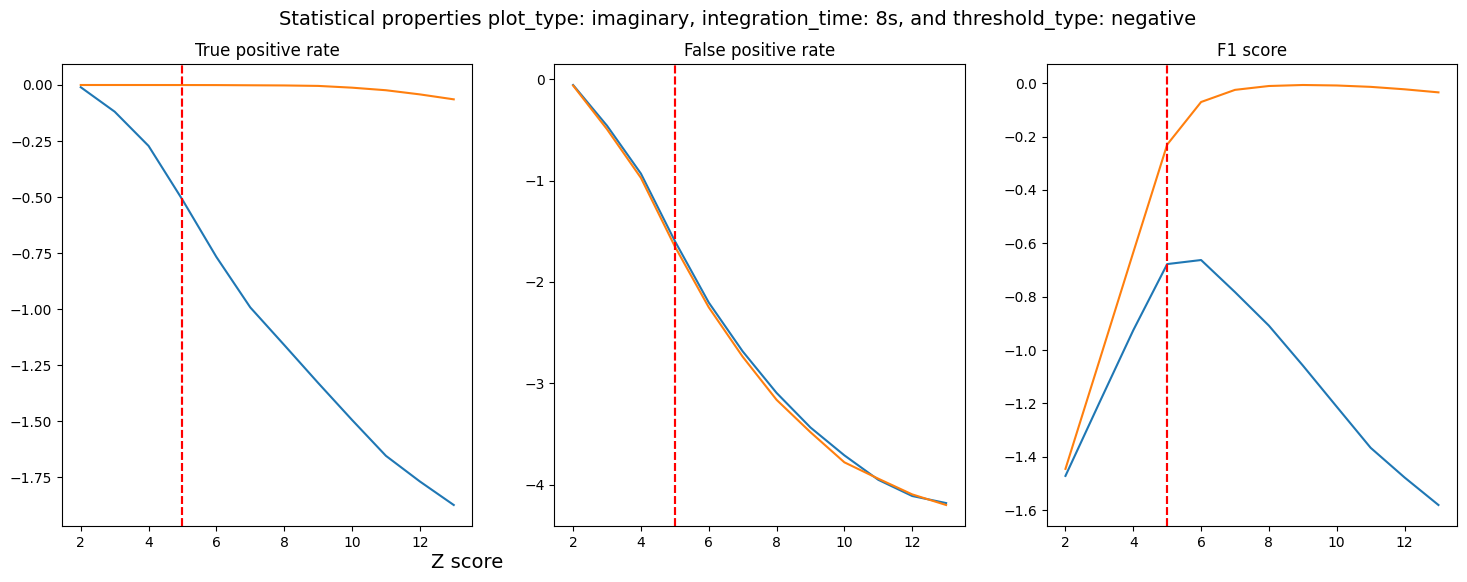

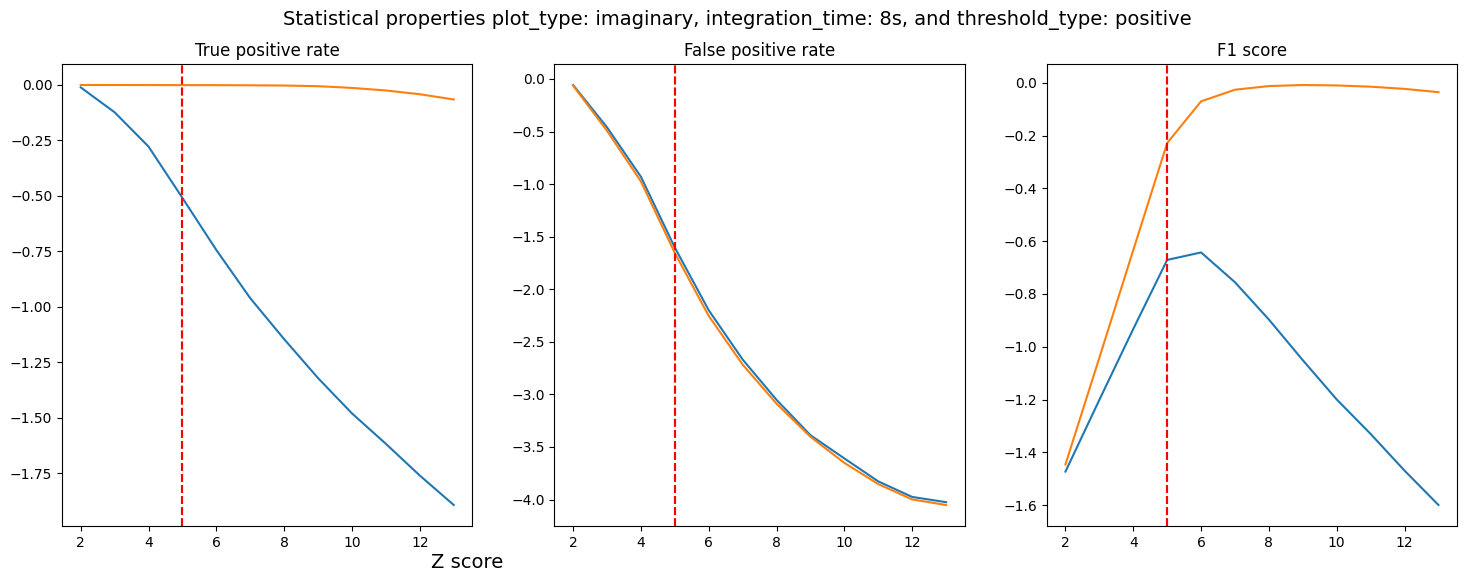

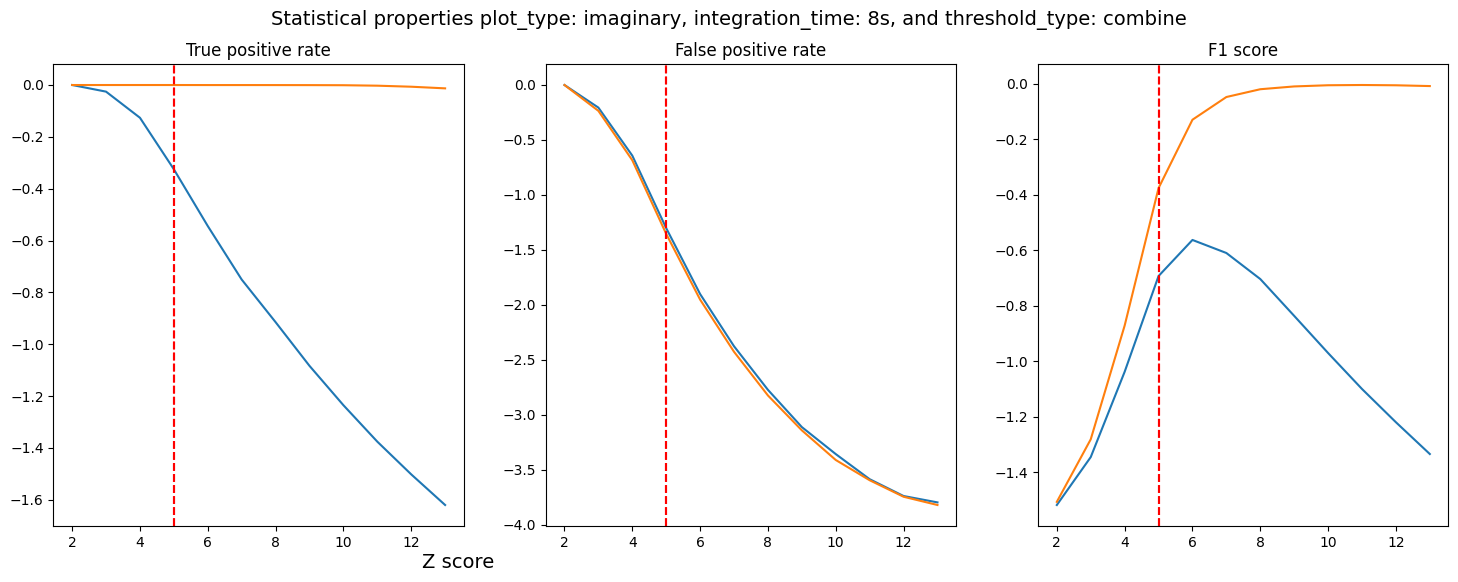

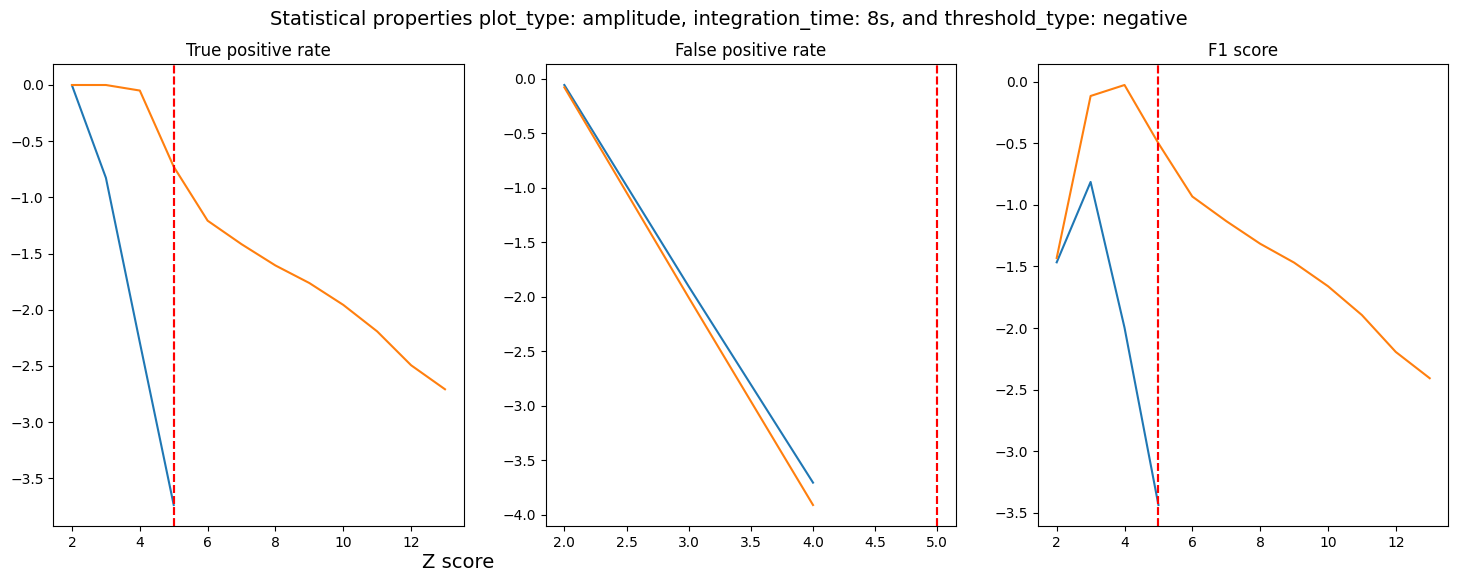

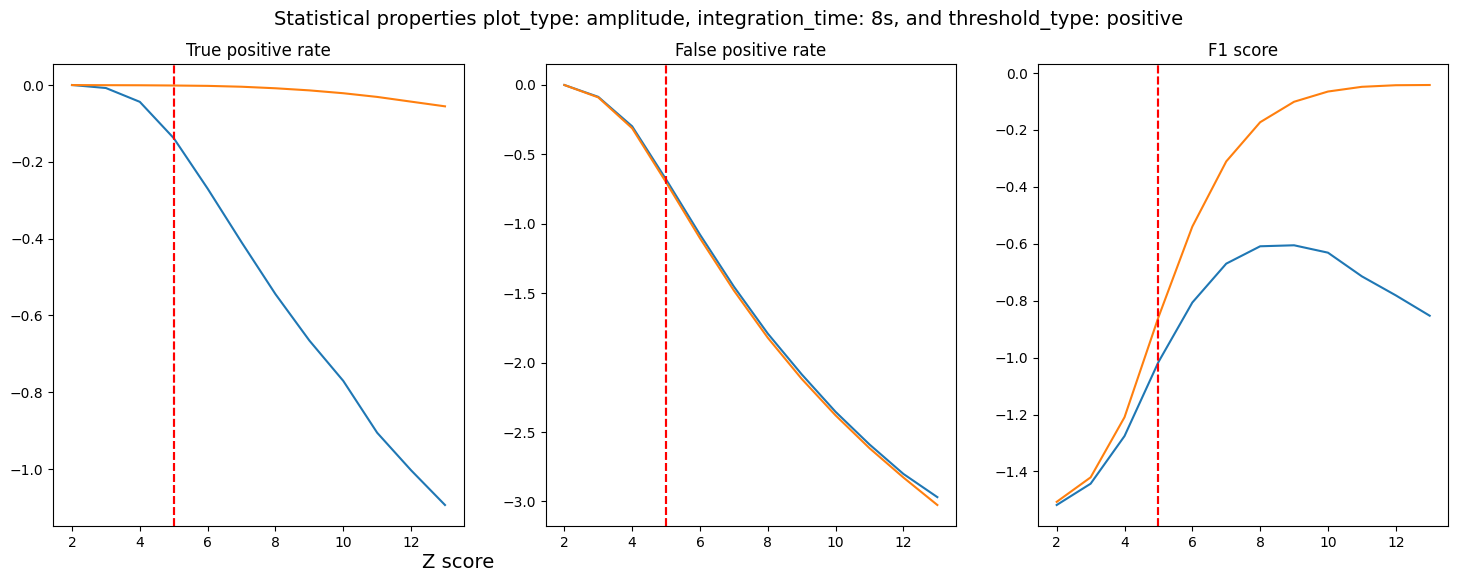

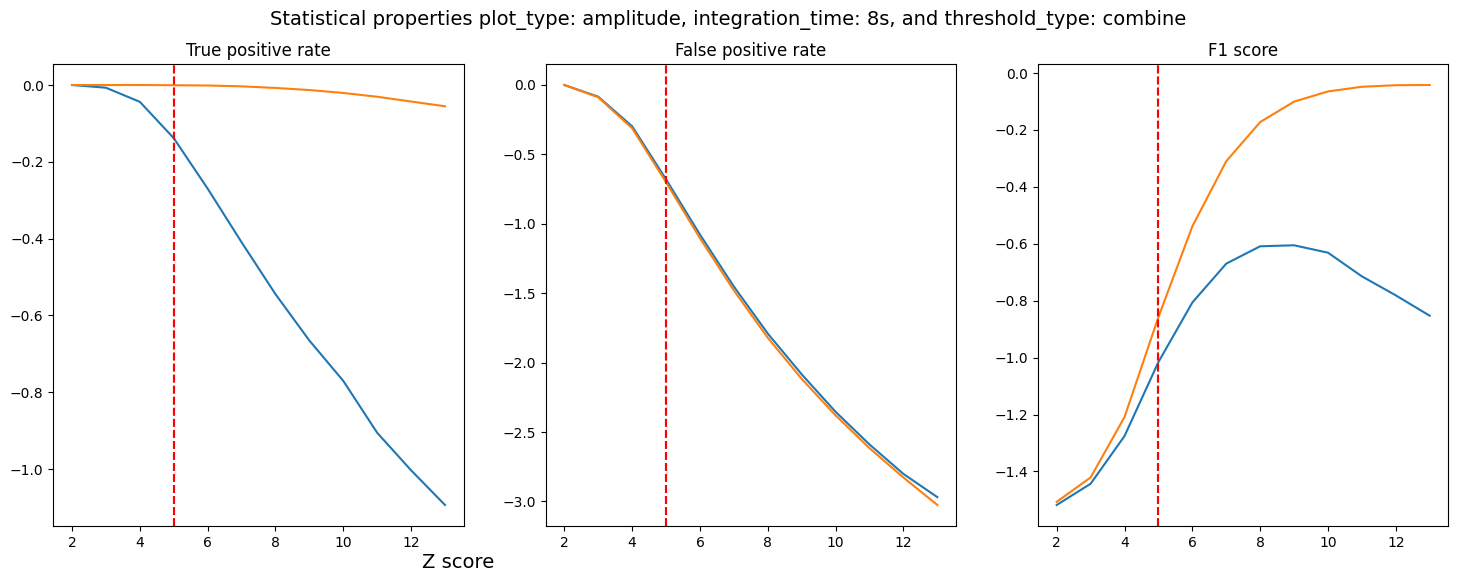

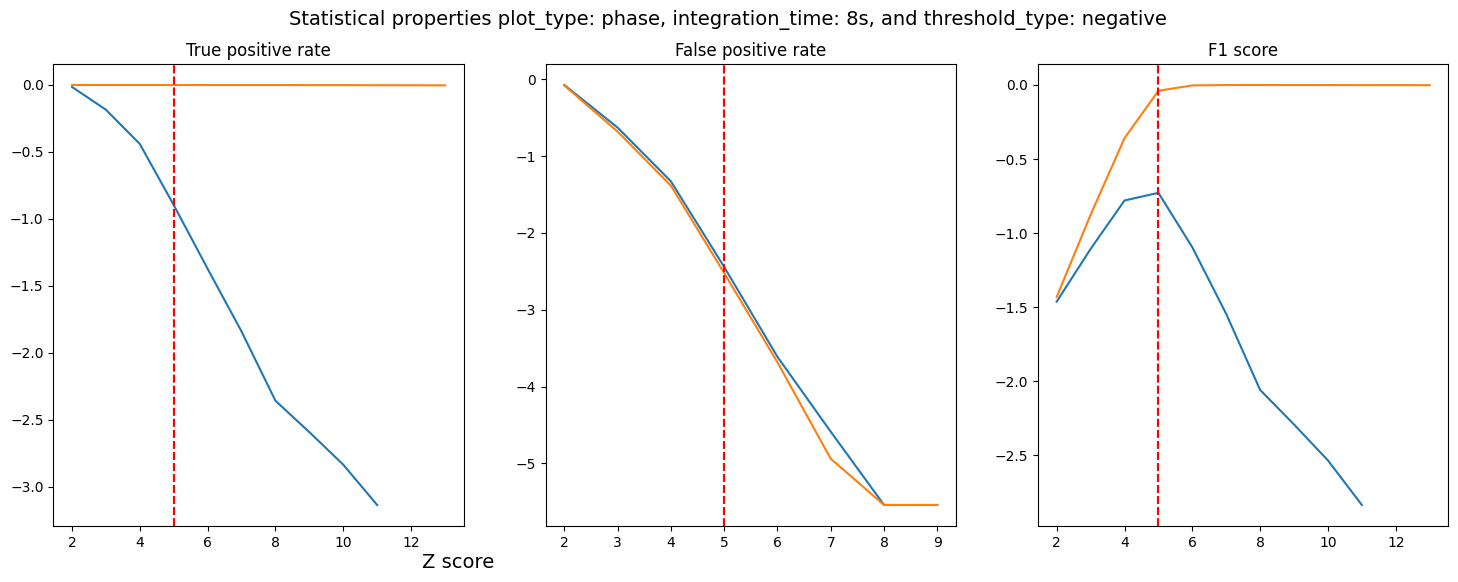

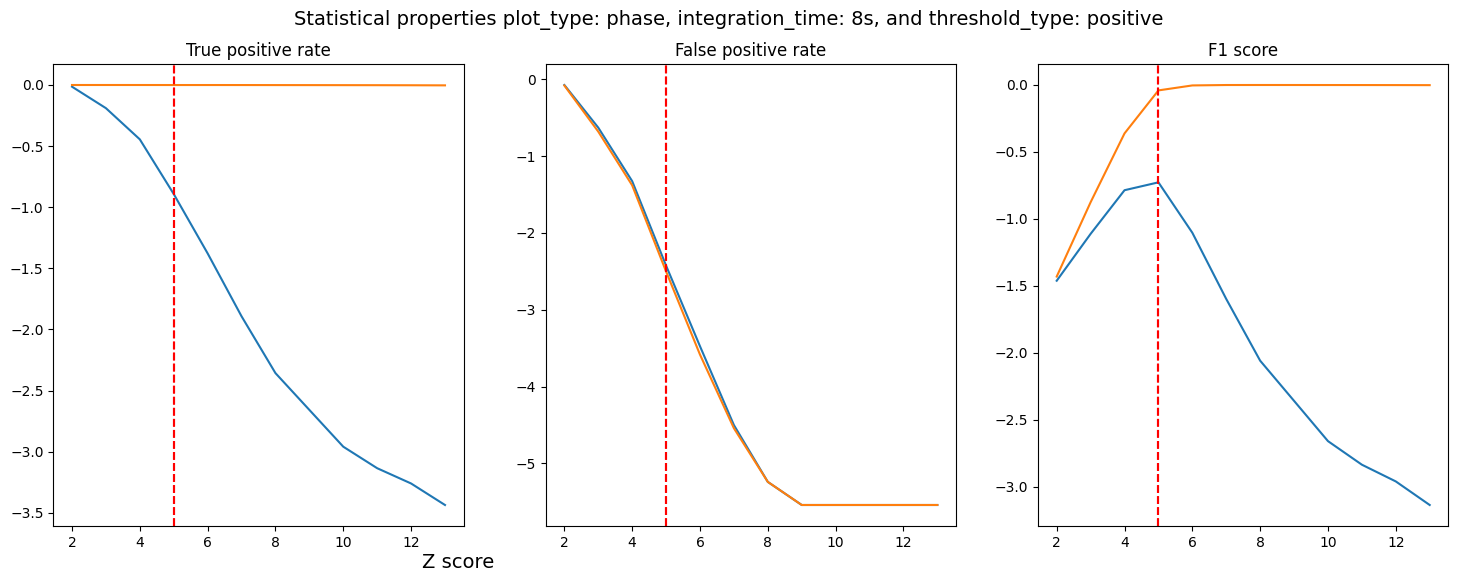

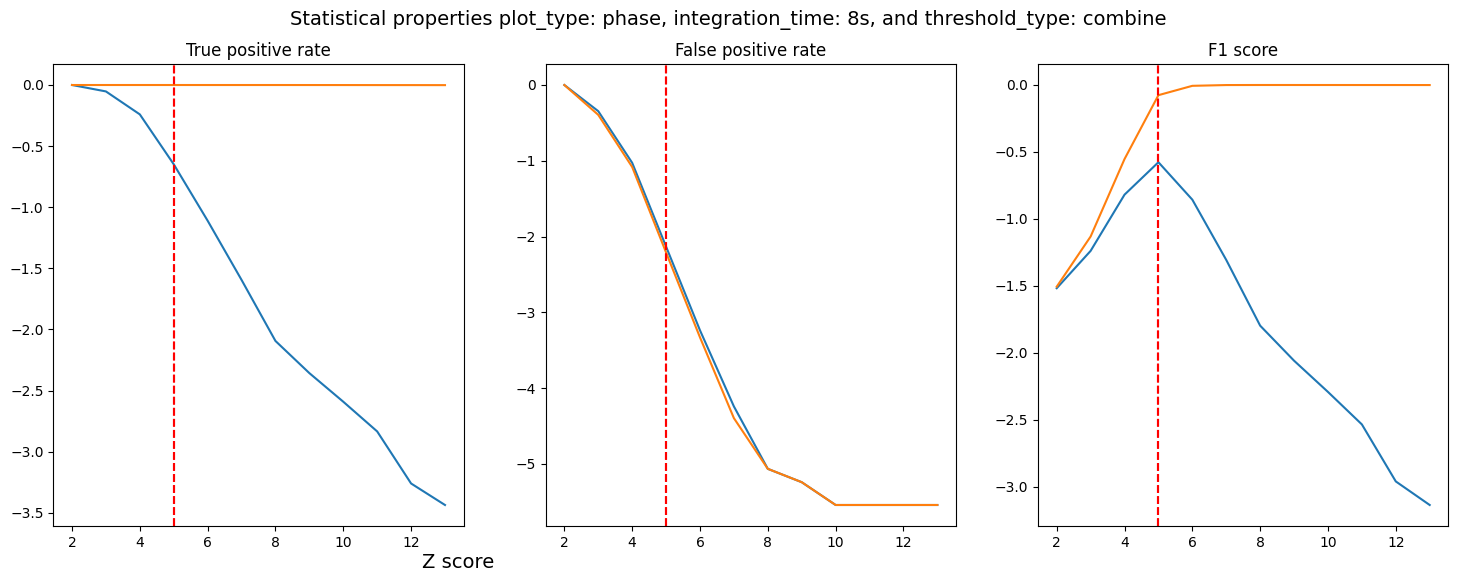

In [10]:
for ii in range(len(parts)):
    for jj in range(len(threshold_type)):
        for kk in range(len(integ)):

            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
            fig.suptitle('Statistical properties plot_type: %s, integration_time: %s, and threshold_type: %s' %(parts[ii], integ[kk], threshold_type[jj]), size=14, y=0.97)

            for ll in range(2):#len(sn)):

                sel_df = df_stats[(df_stats['integration'] == integ[kk]) & (df_stats['plot_type'] == parts[ii]) & (df_stats['sn'] == sn[ll]) & (df_stats['threshold_type'] == threshold_type[jj])][['z_score', 'tp', 'fp', 'f1', 'tp_rate', 'fp_rate']].reset_index(drop=True)

                z_alias['tp'] = z_alias.z_score.map(sel_df.set_index('z_score')['tp_rate'])
                z_alias['fp'] = z_alias.z_score.map(sel_df.set_index('z_score')['fp_rate'])
                z_alias['f1'] = z_alias.z_score.map(sel_df.set_index('z_score')['f1'])

                axes[0].plot(z_score, np.log10(z_alias['tp']), label=str(sn[ll]))
                axes[0].set_title('True positive rate', color='k', size=12)
                axes[0].axvline(x=5, color='red', linestyle='--')

                axes[1].plot(z_score, np.log10(z_alias['fp']), label=str(sn[ll]))
                axes[1].set_title('False positive rate', color='k', size=12)
                axes[1].axvline(x=5, color='red', linestyle='--')

                axes[2].plot(z_score, np.log10(z_alias['f1']), label=str(sn[ll]))
                axes[2].set_title('F1 score', color='k', size=12)
                axes[2].axvline(x=5, color='red', linestyle='--')
            
            fig.text(0.35, 0.04, "Z score", size=14, ha='center')

In [11]:
df_stats[(df_stats['integration'] == '8s') & (df_stats['plot_type'] == parts[ii])][['z_score', 'tp', 'fp', 'f1', 'tp_rate', 'fp_rate']].reset_index(drop=True)

,z_score,tp,fp,f1,tp_rate,fp_rate
0,2,5287,295741,0.034500,0.967075,0.846549
1,2,5295,295868,0.034537,0.968539,0.846912
2,2,5467,349045,0.030374,1.000000,0.999130
3,3,3575,82372,0.078216,0.653924,0.235787
4,3,3533,82406,0.077303,0.646241,0.235884
...,...,...,...,...,...,...
65,12,5585,1,0.997410,0.995012,0.000003
66,12,5603,1,0.999019,0.998218,0.000003
67,13,5577,0,0.996783,0.993586,0.000000
68,13,5574,1,0.996425,0.993052,0.000003
